# Adam (first-order method)
The _adaptive moment estimation_ method, or _Adam_ (see D.Kingma, 2015). Adapts factors to each parameter. It stores both an exponentially decaying squared gradient like RMSProp and Adadelta, but also an exponentially decaying gradient like momentum
    Initializing the gradient and squared gradient to zero introduces a _bias_. A bias correction step helps alleviate the issue. The equations applied during each iteration are:
\begin{align*}
\text{Biased decaying momentum: } \mathbf{v}^{(k+1)} &= \gamma_v\mathbf{v}^{(k)} + (1-\gamma_v)\mathbf{g}^{(k)} \\
\text{Biased decaying sq. gradient: } \mathbf{s}^{(k+1)} &= \gamma_s\mathbf{s}^{(k)} + (1-\gamma_s)\left(\mathbf{g}^{(k)} \odot \mathbf{g}^{(k)}\right) \\
\text{Corrected decaying momentum: }\hat{\mathbf{v}}^{(k+1)} &= \frac{\mathbf{v}^{(k+1)}}{1-\gamma_v^k} \\
\text{Corrected decaying sq. gradient: }\hat{\mathbf{s}}^{(k+1)} &= \frac{\mathbf{s}^{(k+1)}}{1-\gamma_s^k} \\
\text{Next iterate: }\mathbf{x}^{(k+1)} &= \mathbf{x}^{(k)} - \alpha \frac{\hat{\mathbf{v}}^{(k+1)}}{\varepsilon + \sqrt{\hat{\mathbf{s}}^{(k+1)}}}
\end{align*}
$$$$
_According to the original paper_, good default settings are $\alpha=0.001$, $\gamma_v=0.9$, $\gamma_s=0.999$ and $\epsilon=10^{-8}$

As is family of the descent methods

In [ ]:
from abc import ABC, abstractmethod
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

class DescentMethod(ABC):
    @abstractmethod
    def init(self, f, grad_f, x0):
        """Initialize the descent method"""
        pass
    
    @abstractmethod
    def step(self, f, grad_f, x):
        """Perform one optimization step"""
        pass

def iterated_descent(method: DescentMethod, f, grad_f, x0, k_max=1000, tol=1e-8):
    """
    Perform iterative descent optimization
    """
    method.init(f, grad_f, x0)
    x = x0.copy()
    history = [x.copy()]
    prev_loss = f(x)
    
    for i in range(k_max):
        x_new = method.step(f, grad_f, x)
        current_loss = f(x_new)
        
        # Check for convergence based on parameter change and loss change
        param_change = jnp.linalg.norm(x_new - x)
        loss_change = abs(current_loss - prev_loss)
        
        if param_change < tol and loss_change < tol:
            print(f"Converged after {i+1} iterations")
            break
            
        x = x_new
        prev_loss = current_loss
        history.append(x.copy())
        
        # Print progress every 100 iterations
        if (i + 1) % 100 == 0:
            print(f"Iteration {i+1}: Loss = {current_loss:.6e}")
    
    return x, jnp.array(history)

And now the algorithm

Iteration 100: Loss = 3.576109e+00
Iteration 200: Loss = 3.107449e+00
Iteration 300: Loss = 2.565411e+00
Iteration 400: Loss = 1.858888e+00
Iteration 500: Loss = 8.952858e-01
Iteration 600: Loss = 4.797501e-01
Iteration 700: Loss = 3.178387e-01
Iteration 800: Loss = 2.273536e-01
Iteration 900: Loss = 1.686690e-01
Iteration 1000: Loss = 1.276461e-01
Iteration 1100: Loss = 9.769654e-02
Iteration 1200: Loss = 7.523163e-02
Iteration 1300: Loss = 5.808559e-02
Iteration 1400: Loss = 4.485324e-02
Iteration 1500: Loss = 3.457264e-02
Iteration 1600: Loss = 2.655769e-02
Iteration 1700: Loss = 2.030350e-02
Iteration 1800: Loss = 1.542902e-02
Iteration 1900: Loss = 1.164121e-02
Iteration 2000: Loss = 8.711144e-03
Iteration 2100: Loss = 6.458193e-03
Iteration 2200: Loss = 4.738544e-03
Iteration 2300: Loss = 3.437316e-03
Iteration 2400: Loss = 2.462438e-03
Iteration 2500: Loss = 1.740242e-03
Iteration 2600: Loss = 1.211863e-03
Iteration 2700: Loss = 8.306107e-04
Iteration 2800: Loss = 5.596397e-04
I

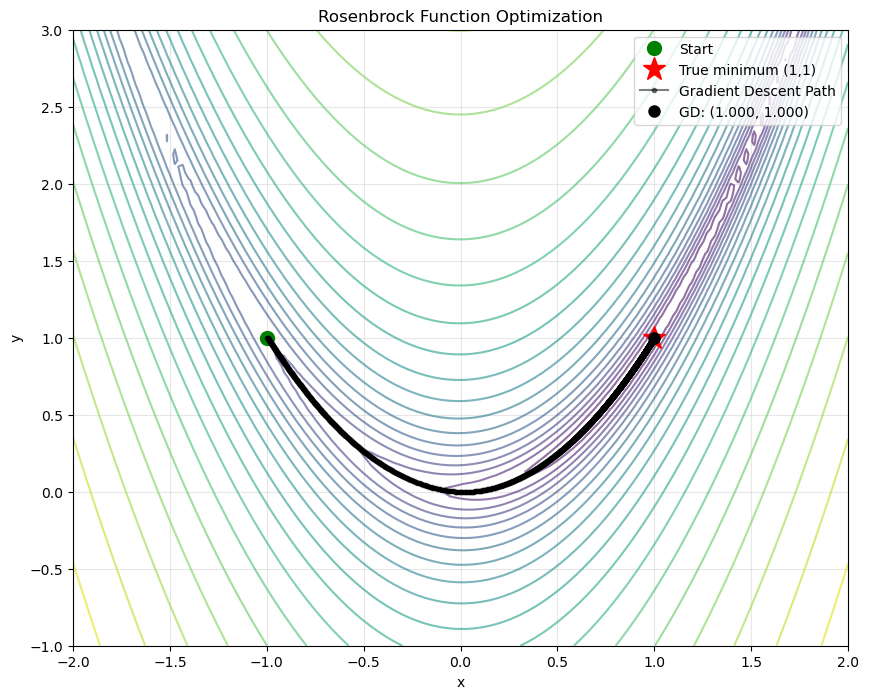

Gradient Descent final error: 0.000005


In [ ]:
class AdamOptimizer(DescentMethod):
    """Adam optimizer"""
    def __init__(self, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.alpha = alpha      # Learning rate (α)
        self.beta1 = beta1      # Exponential decay rate for 1st moment (β₁)
        self.beta2 = beta2      # Exponential decay rate for 2nd moment (β₂)
        self.epsilon = epsilon  # Small constant for numerical stability (ε)
        self.k = 0              # Time step counter (k)
        self.m = None           # 1st moment vector (m)
        self.v = None           # 2st moment vector (v)
        
    def init(self, f, grad_f, x0):
        # initialize moment vectors to zero
        self.m = jnp.zeros_like(x0)
        self.v = jnp.zeros_like(x0)
        self.k = 0
        return self
    
    def step(self, f, grad_f, x):
        self.k += 1
        grad = grad_f(x)  # current gradient (gₜ)
        
        # Equation 1: Update biased first moment estimate
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        
        # Equation 2: Update biased second moment estimate
        self.v = self.beta2 * self.v + (1 - self.beta2) * grad**2
        
        # Equation 3: Compute bias-corrected first moment
        m_hat = self.m / (1 - self.beta1**self.k)
        
        # Equation 4: Compute bias-corrected second moment
        v_hat = self.v / (1 - self.beta2**self.k)
        
        # Equation 5: Next iterate
        return x - self.alpha * m_hat / (jnp.sqrt(v_hat) + self.epsilon)

def rosenbrock(x):
    """Rosenbrock function: f(x,y) = (a-x)² + b(y-x²)² with a=1, b=100"""
    a, b = 1, 100 # as figure 5.5 from AFO
    return (a - x[0])**2 + b * (x[1] - x[0]**2)**2

def rosenbrock_grad(x):
    """Gradient of Rosenbrock function"""
    a, b = 1, 100
    dx = -2*(a - x[0]) - 4*b*x[0]*(x[1] - x[0]**2)
    dy = 2*b*(x[1] - x[0]**2)
    return jnp.array([dx, dy])

def run_optim(method, f, grad_f, x0, k_max, method_name):
    result, history = iterated_descent(method, f, grad_f, x0, k_max)
    print(f'{method_name}')
    print(f'    Starting point: {x0}')
    print(f'    Final point {result}')
    print(f'    Function value: {f(result):.4f}')
    print(f'    Distance from true minimum (1, 1): {jnp.linalg.norm(result - jnp.array([1,1])):.3f}')
    return result, history

# --- parameters ---
x0 = jnp.array([-1.0, 1.0])
step_size = 0.002
mom_decay = 0.9
max_iter = 10000
# --- establish methods ---
gd = AdamOptimizer(alpha=step_size)
# --- history ---
result_ad, history_ad = run_optim(gd, rosenbrock, rosenbrock_grad,
                       x0, max_iter, f"Adam Optim with recommended hyperparams")
# --- plot ---
plt.figure(figsize=(10,8))
x_range = jnp.linspace(-2, 2, 100)
y_range = jnp.linspace(-1, 3, 100)
X, Y = jnp.meshgrid(x_range, y_range)
Z = (1 - X)**2 + 100 * (Y - X**2)**2
# --- countor plot (isovalues) ---
plt.contour(X,Y, jnp.log(Z+1), levels=20, alpha=0.6)
plt.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
plt.plot(1,1, 'r*', markersize=17, label='True minimum (1,1)')
# --- path of the method ---
plt.plot(history_ad[:,0], history_ad[:,1], '.-', color='black', alpha=0.5,
         label='Adam Path') # optimization history
# --- final points of the methods ---
plt.plot(result_ad[0], result_ad[1], 'o', color='black', markersize=8,
         label=f'GD: ({result_ad[0]:.3f}, {result_ad[1]:.3f})') # final points
# --- personalization ---
plt.xlabel('x')
plt.ylabel('y')
plt.title('Rosenbrock Function Optimization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print(f"Adam final error: {jnp.linalg.norm(result_ad - jnp.array([1,1])):.6f}")